# 今回の取り組み

- Tyr50%,10%のアルビノアレルが無くなったので原因を調べます

## いつものセットアップ

In [1]:
# ルートディレクトリをPathに含めるおまじない
import sys, os
from pathlib import Path
if Path(os.getcwd()).stem != "DAJIN2":
    parent_path = str(Path(os.path.dirname(os.path.abspath("__file__"))).parent.parent)
    sys.path.append(parent_path)
    os.chdir(parent_path)

print(os.getcwd())
sys.path.append(os.getcwd() + "/" + "src")

/mnt/d/Research/DAJIN2


In [2]:
%%bash
# pipの更新
pip install -q -U pip
pip install -q -U -r requirements.txt

# 実験

In [3]:
from __future__ import annotations

import sys, os
from pathlib import Path

import hashlib
from collections import defaultdict
from pathlib import Path
from importlib import reload

from src.DAJIN2.core import preprocess, classification, clustering, consensus, report

reload(preprocess)
reload(classification)
reload(clustering)
reload(consensus)
reload(report)

#### # * Subset of Point mutation
#### # 50 or 10 or 01%
percent = "50"
SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
    f"misc/data/tyr_albino_{percent}%.fq.gz",
    "misc/data/tyr_control.fq.gz",
    "misc/data/tyr_control.fasta",
    "batch_tyr_50_10_01",
    "mm10",
    True,
    30,
)


######################################################################
# Preprocessing
######################################################################

print(f"processing {NAME}...")

SAMPLE = preprocess.format_inputs.convert_to_posix_path(SAMPLE)
CONTROL = preprocess.format_inputs.convert_to_posix_path(CONTROL)
ALLELE = preprocess.format_inputs.convert_to_posix_path(ALLELE)

# ====================================================================
# Varidate inputs
# ====================================================================

preprocess.validate_inputs.check_files(SAMPLE, CONTROL, ALLELE)
TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
IS_CACHE_CONTROL = preprocess.validate_inputs.exists_cached_control(CONTROL, TEMPDIR)
IS_CACHE_GENOME = preprocess.validate_inputs.exists_cached_genome(GENOME, TEMPDIR, IS_CACHE_CONTROL)
UCSC_URL, GOLDENPATH_URL = None, None
if GENOME and not IS_CACHE_GENOME:
    UCSC_URL, GOLDENPATH_URL = preprocess.validate_inputs.check_and_fetch_genome(GENOME)

# ====================================================================
# Format inputs
# ====================================================================
SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)
THREADS = preprocess.format_inputs.update_threads(THREADS)

preprocess.format_inputs.make_directories(TEMPDIR, SAMPLE_NAME, CONTROL_NAME)

if GENOME:
    GENOME_COODINATES = preprocess.format_inputs.fetch_coodinate(GENOME, UCSC_URL, FASTA_ALLELES["control"])
    CHROME_SIZE = preprocess.format_inputs.fetch_chrom_size(GENOME_COODINATES["chr"], GENOME, GOLDENPATH_URL)
    preprocess.format_inputs.cache_coodinates_and_chromsize(TEMPDIR, GENOME, GENOME_COODINATES, CHROME_SIZE)


processing batch_tyr_50_10_01...


In [9]:
# いったん補正前にリセットします
import shutil
shutil.copytree(Path(TEMPDIR, "midsv_control"), Path(TEMPDIR, "midsv"), dirs_exist_ok=True)
for allele in FASTA_ALLELES:
    preprocess.call_midsv(TEMPDIR, SAMPLE_NAME, allele)
preprocess.replace_NtoD(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME)

In [10]:
import midsv
allele = "control"
midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.jsonl")))
midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl")))

In [15]:
idx_mutation = 828
count_mutation = defaultdict(int)
for samp in midsv_sample:
    count_mutation[samp["CSSPLIT"].split(",")[idx_mutation]] += 1

print(count_mutation)

defaultdict(<class 'int'>, {'=G': 2501, '*GT': 2475, '+T|=G': 1, '-G': 9, 'N': 8, '*GA': 4, '+A|=G': 1, '+A|+A|*GA': 1})


In [16]:
count_mutation = defaultdict(int)
for cont in midsv_control:
    count_mutation[cont["CSSPLIT"].split(",")[idx_mutation]] += 1

print(count_mutation)

defaultdict(<class 'int'>, {'=G': 9949, '+T|=G': 1, '-G': 16, '*GA': 7, '+A|=G': 3, 'N': 12, '*GT': 8, '+A|+A|*GA': 1, '+C|+A|*GA': 1, '+A|*GT': 2})


In [17]:
from __future__ import annotations

import random
import re
from collections import Counter
from collections import defaultdict
from pathlib import Path

import midsv
from scipy import stats
from scipy.spatial import distance
from sklearn.neighbors import LocalOutlierFactor


def _count_indels(cssplits: list[list[str]]) -> dict[str, list[int]]:
    count = {"ins": [1] * len(cssplits[0]),
            "del": [1] * len(cssplits[0]),
            "sub": [1] * len(cssplits[0])}
    transposed_cssplits = [list(t) for t in zip(*cssplits)]
    for i, transposed_cssplit in enumerate(transposed_cssplits):
        for cs in transposed_cssplit:
            if cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                continue
            if cs.startswith("+"):
                count["ins"][i] += len(cs.split("|"))
            elif cs.startswith("-"):
                count["del"][i] += 1
            elif cs.startswith("*"):
                count["sub"][i] += 1
    return count

def _remove_minor_indels(count_indels: dict[str, list[int]], coverage: int) -> dict[str, list[int]]:
    count_indels_removed = dict()
    threshold = coverage * 0.01
    for key, values in count_indels.items():
        values_removed = [v if v >= threshold else 1 for v in values]
        count_indels_removed.update({key: values_removed})
    return count_indels_removed


def _extract_anomaly_loci(indels_sample: dict, indels_control: dict) -> dict[str, set[int]]:
    anomaly_loci = dict()
    for key in indels_sample.keys():
        clf = LocalOutlierFactor(novelty=True)
        clf.fit(indels_control[key])
        pred = clf.predict(indels_sample[key])
        # はじめの9塩基はまず正常と判定されるはずなので、これをもとにして正常か異常かを判定する
        normal, abnormal = Counter(pred).keys()
        if Counter(pred[:9]).most_common()[0][0] == abnormal:
            normal, abnormal = abnormal, normal
        loci = {i for i, p in enumerate(pred) if p == abnormal}
        anomaly_loci.update({key: loci})
    return anomaly_loci


def _split_kmer(indels: dict[str, list[int]], kmer: int = 10) -> dict[str, list[list[int]]]:
    results = defaultdict(list)
    center = kmer // 2
    for mut, value in indels.items():
        for i in range(len(value)):
            if center <= i <= len(value) - center:
                start = i - center
                if kmer % 2 == 0:
                    end = i + center
                else:
                    end = i + center + 1
                results[mut].append(value[start : end])
            else:
                results[mut].append([0]*kmer)
    return results


def _extract_dissimilar_loci(indels_kmer_sample: dict[str, list[list[int]]], indels_kmer_control: dict[str, list[list[int]]]) -> dict[str, set]:
    results = dict()
    for mut in indels_kmer_sample:
        cossim = [distance.cosine(x, y) for x, y in zip(indels_kmer_sample[mut], indels_kmer_control[mut])]
        pvalues = [stats.ttest_ind(x, y, equal_var=False)[1] for x, y in zip(indels_kmer_sample[mut], indels_kmer_control[mut])]
        cossim_pval_false = [cossim if pvalue > 0.05 else 1 for cossim, pvalue in zip(cossim, pvalues)]
        dissimilar_loci = {i for i, x in enumerate(cossim_pval_false) if x > 0.05}
        results.update({mut: dissimilar_loci})
    return results


def _extract_mutation_loci(cssplits_sample, cssplits_control) -> dict[str, set[int]]:
    indels_sample = _count_indels(cssplits_sample)
    indels_control = _count_indels(cssplits_control)
    indels_sample = _remove_minor_indels(indels_sample, len(cssplits_sample))
    indels_control = _remove_minor_indels(indels_control, len(cssplits_control))
    # Difference of anomaly within kmers
    indels_kmer_sample = _split_kmer(indels_sample, kmer = 10)
    indels_kmer_control = _split_kmer(indels_control, kmer = 10)
    anomaly_loci = _extract_anomaly_loci(indels_kmer_sample, indels_kmer_control)
    dissimilar_loci = _extract_dissimilar_loci(indels_kmer_sample, indels_kmer_control)
    mutation_loci = dict()
    for mut in anomaly_loci:
        mutation_loci.update({mut: anomaly_loci[mut] & dissimilar_loci[mut]})
    return mutation_loci

###########################################################
# postprocesss
###########################################################


def _replace_errors_to_atmark(cssplits_sample: list[list[str]], mutation_loci: dict[str, set[int]]) -> list[list[str]]:
    results = []
    for cssplits in cssplits_sample:
        cssplits_replaced = []
        for i, cs in enumerate(cssplits):
            if cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                cssplits_replaced.append(cs)
                continue
            if cs.startswith("+"):
                tag = "ins"
            elif cs.startswith("-"):
                tag = "del"
            else:
                tag = "sub"
            if i in mutation_loci[tag]:
                cssplits_replaced.append(cs)
            else:
                cssplits_replaced.append("@")
        results.append(cssplits_replaced)
    return results


def _replace_atmark(cssplits: list[list[str]], sequence: str) -> list[list[str]]:
    random.seed(1)
    cssplits_replaced = cssplits.copy()
    sequence_length = len(sequence)
    for i in range(1, sequence_length - 1):
        cssplits_atmark = defaultdict(str)
        cssplits_sampling_key = defaultdict(list)
        cssplits_sampling_all = []
        flag_all_atmark = True
        for idx, cssplit in enumerate(cssplits):
            key = ",".join([cssplit[i - 1], cssplit[i + 1]])
            if cssplit[i] == "@":
                cssplits_atmark[idx] = key
            else:
                cssplits_sampling_key[key].append(cssplit[i])
                cssplits_sampling_all.append(cssplit[i])
                flag_all_atmark = False
        for idx, key in cssplits_atmark.items():
            if flag_all_atmark:
                cssplits_replaced[idx][i] = "N"
            elif cssplits_sampling_key[key]:
                cssplits_replaced[idx][i] = random.choice(cssplits_sampling_key[key])
            else:
                cssplits_replaced[idx][i] = random.choice(cssplits_sampling_all)
    for cs in cssplits_replaced:
        if cs[0] == "@":
            cs[0] = "N"
        if cs[-1] == "@":
            cs[-1] = "N"
    return cssplits_replaced

###############################################################################
# main
###############################################################################


def execute(TEMPDIR: Path, FASTA_ALLELES: dict[str, str], CONTROL_NAME: str, SAMPLE_NAME: str) -> None:
    for allele, sequence in FASTA_ALLELES.items():
        midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.jsonl")))
        midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl")))
        cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
        cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
        # Extract mutation loci
        mutation_loci = _extract_mutation_loci(cssplits_sample, cssplits_control)
        # Correct sequence errors
        cssplits_sample_atmark = _replace_errors_to_atmark(cssplits_sample, mutation_loci)
        cssplits_control_atmark = _replace_errors_to_atmark(cssplits_control, mutation_loci)
        cssplits_sample_atmark_replaced = _replace_atmark(cssplits_sample_atmark, sequence)
        cssplits_control_atmark_replaced = _replace_atmark(cssplits_control_atmark, sequence)
        # Replace CSSPLIT
        cssplits_sample_corrected = [",".join(cs) for cs in cssplits_sample_atmark_replaced]
        cssplits_control_corrected = [",".join(cs) for cs in cssplits_control_atmark_replaced]
        for i, cssplits in enumerate(cssplits_sample_corrected):
            midsv_sample[i]["CSSPLIT"] = cssplits
        for i, cssplits in enumerate(cssplits_control_corrected):
            midsv_control[i]["CSSPLIT"] = cssplits
        midsv.write_jsonl(midsv_sample, Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.jsonl"))
        midsv.write_jsonl(midsv_control, Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl"))


In [18]:
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
# Extract mutation loci
mutation_loci = _extract_mutation_loci(cssplits_sample, cssplits_control)

In [20]:
idx_mutation in mutation_loci["sub"]

False

In [21]:
indels_sample = _count_indels(cssplits_sample)
indels_control = _count_indels(cssplits_control)
indels_sample = _remove_minor_indels(indels_sample, len(cssplits_sample))
indels_control = _remove_minor_indels(indels_control, len(cssplits_control))
# Difference of anomaly within kmers
indels_kmer_sample = _split_kmer(indels_sample, kmer = 10)
indels_kmer_control = _split_kmer(indels_control, kmer = 10)
anomaly_loci = _extract_anomaly_loci(indels_kmer_sample, indels_kmer_control)
dissimilar_loci = _extract_dissimilar_loci(indels_kmer_sample, indels_kmer_control)
mutation_loci = dict()
for mut in anomaly_loci:
    mutation_loci.update({mut: anomaly_loci[mut] & dissimilar_loci[mut]})


In [23]:
print(indels_kmer_sample["sub"][idx_mutation])
print(indels_kmer_control["sub"][idx_mutation])

[1, 1, 1, 1, 1, 2480, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [26]:
print(idx_mutation in anomaly_loci["sub"])
print(idx_mutation in dissimilar_loci["sub"])

False
True


- anomaly_lociに問題あり！

In [28]:
key="sub"
clf = LocalOutlierFactor(novelty=True)
clf.fit(indels_kmer_control[key])
pred = clf.predict(indels_kmer_sample[key])
# はじめの9塩基はまず正常と判定されるはずなので、これをもとにして正常か異常かを判定する
normal, abnormal = Counter(pred).keys()
if Counter(pred[:9]).most_common()[0][0] == abnormal:
    normal, abnormal = abnormal, normal
loci = {i for i, p in enumerate(pred) if p == abnormal}


In [32]:
print(pred[:10])
print(pred[820:830])
print(Counter(pred))

[-1 -1 -1 -1 -1  1  1  1  1  1]
[-1  1  1  1 -1 -1 -1 -1 -1 -1]
Counter({1: 2058, -1: 787})


In [35]:
print(indels_kmer_sample["sub"][10])
print(indels_kmer_control["sub"][10])

[1, 1, 1, 1, 137, 1, 98, 69, 1, 1]
[1, 114, 1, 1, 299, 1, 131, 1, 1, 1]


In [52]:
import numpy as np

In [54]:
for key in indels_kmer_sample:
    indels_normalized_sample = np.array(indels_kmer_sample[key]) / len(cssplits_sample)
    indels_normalized_control = np.array(indels_kmer_control[key]) / len(cssplits_control)
    meanstd_sample = []
    for values in indels_normalized_sample:
        mean, sdt = np.mean(values, axis=0), np.std(values, axis=0)
        meanstd_sample.append([mean, sdt])
    meanstd_control = []
    for values in indels_normalized_control:
        mean, sdt = np.mean(values, axis=0), np.std(values, axis=0)
        meanstd_control.append([mean, sdt])


ins [0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002]
ins [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001]
del [0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002]
del [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001]
sub [0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.496, 0.0002, 0.0002, 0.0002, 0.0002]
sub [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001]


In [60]:
print(meanstd_sample[828])
print(meanstd_control[828])

[0.04978, 0.14874]
[0.0001, 0.0]


In [79]:
key="sub"
clf = LocalOutlierFactor(novelty=True)
clf.fit(meanstd_control)
pred = clf.predict(meanstd_sample)
loci = {i for i, p in enumerate(pred) if p == -1}


In [81]:
print(828 in loci)
print(pred[:100])
print(pred[800:850])
print(Counter(pred))
print(Counter(pred))

True
[-1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1]
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
  1  1]
Counter({1: 2517, -1: 328})
Counter({1: 2517, -1: 328})


- LOFの異常を`-1`にしたらうまく行きそうです
    - 「はじめの9塩基はまず正常と判定される」という前提が間違っていました
    - はじめの9塩基も容赦なく異常と判定されます

In [83]:
def _extract_anomaly_loci(indels_sample: dict, indels_control: dict) -> dict[str, set[int]]:
    anomaly_loci = dict()
    for key in indels_sample.keys():
        clf = LocalOutlierFactor(novelty=True)
        clf.fit(indels_control[key])
        pred = clf.predict(indels_sample[key])
        loci = {i for i, p in enumerate(pred) if p == -1}
        anomaly_loci.update({key: loci})
    return anomaly_loci


In [84]:
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
# Extract mutation loci
mutation_loci = _extract_mutation_loci(cssplits_sample, cssplits_control)

In [85]:
828 in mutation_loci["sub"]

True

- 50%は良さそうなので、次は10%をテストします

In [87]:
from __future__ import annotations

from pathlib import Path

from pathlib import Path
from importlib import reload

from src.DAJIN2.core import preprocess, classification, clustering, consensus, report

#### # * Subset of Point mutation
#### # 50 or 10 or 01%
percent = "10"
SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
    f"misc/data/tyr_albino_{percent}%.fq.gz",
    "misc/data/tyr_control.fq.gz",
    "misc/data/tyr_control.fasta",
    "batch_tyr_50_10_01",
    "mm10",
    True,
    30,
)


preprocess.validate_inputs.check_files(SAMPLE, CONTROL, ALLELE)
TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
IS_CACHE_CONTROL = preprocess.validate_inputs.exists_cached_control(CONTROL, TEMPDIR)
IS_CACHE_GENOME = preprocess.validate_inputs.exists_cached_genome(GENOME, TEMPDIR, IS_CACHE_CONTROL)
UCSC_URL, GOLDENPATH_URL = None, None
if GENOME and not IS_CACHE_GENOME:
    UCSC_URL, GOLDENPATH_URL = preprocess.validate_inputs.check_and_fetch_genome(GENOME)

# ====================================================================
# Format inputs
# ====================================================================
SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)
THREADS = preprocess.format_inputs.update_threads(THREADS)

preprocess.format_inputs.make_directories(TEMPDIR, SAMPLE_NAME, CONTROL_NAME)

if GENOME:
    GENOME_COODINATES = preprocess.format_inputs.fetch_coodinate(GENOME, UCSC_URL, FASTA_ALLELES["control"])
    CHROME_SIZE = preprocess.format_inputs.fetch_chrom_size(GENOME_COODINATES["chr"], GENOME, GOLDENPATH_URL)
    preprocess.format_inputs.cache_coodinates_and_chromsize(TEMPDIR, GENOME, GENOME_COODINATES, CHROME_SIZE)

print(NAME, SAMPLE_NAME, CONTROL_NAME)

batch_tyr_50_10_01


In [88]:
# いったん補正前にリセットします
import shutil
shutil.copytree(Path(TEMPDIR, "midsv_control"), Path(TEMPDIR, "midsv"), dirs_exist_ok=True)
for allele in FASTA_ALLELES:
    preprocess.call_midsv(TEMPDIR, SAMPLE_NAME, allele)
preprocess.replace_NtoD(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME)

In [89]:
import midsv
allele = "control"
midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.jsonl")))
midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl")))

In [90]:
idx_mutation = 828
count_mutation = defaultdict(int)
for samp in midsv_sample:
    count_mutation[samp["CSSPLIT"].split(",")[idx_mutation]] += 1

print(count_mutation)

defaultdict(<class 'int'>, {'=G': 8963, '*GT': 995, '+T|=G': 1, '-G': 16, '*GA': 7, '+A|=G': 3, 'N': 11, '+A|+A|*GA': 1, '+C|+A|*GA': 1, '+A|*GT': 2})


In [91]:
count_mutation = defaultdict(int)
for cont in midsv_control:
    count_mutation[cont["CSSPLIT"].split(",")[idx_mutation]] += 1

print(count_mutation)

defaultdict(<class 'int'>, {'=G': 9949, '+T|=G': 1, '-G': 16, '*GA': 7, '+A|=G': 3, 'N': 12, '*GT': 8, '+A|+A|*GA': 1, '+C|+A|*GA': 1, '+A|*GT': 2})


In [92]:
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
# Extract mutation loci
mutation_loci = _extract_mutation_loci(cssplits_sample, cssplits_control)

In [93]:
828 in mutation_loci["sub"]

True

- 10%もOKなので、最後に01%をテストします

In [94]:
from __future__ import annotations

from pathlib import Path

from pathlib import Path
from importlib import reload

from src.DAJIN2.core import preprocess, classification, clustering, consensus, report

#### # * Subset of Point mutation
#### # 50 or 10 or 01%
percent = "01"
SAMPLE, CONTROL, ALLELE, NAME, GENOME, DEBUG, THREADS = (
    f"misc/data/tyr_albino_{percent}%.fq.gz",
    "misc/data/tyr_control.fq.gz",
    "misc/data/tyr_control.fasta",
    "batch_tyr_50_10_01",
    "mm10",
    True,
    30,
)


preprocess.validate_inputs.check_files(SAMPLE, CONTROL, ALLELE)
TEMPDIR = Path("DAJINResults", ".tempdir", NAME)
IS_CACHE_CONTROL = preprocess.validate_inputs.exists_cached_control(CONTROL, TEMPDIR)
IS_CACHE_GENOME = preprocess.validate_inputs.exists_cached_genome(GENOME, TEMPDIR, IS_CACHE_CONTROL)
UCSC_URL, GOLDENPATH_URL = None, None
if GENOME and not IS_CACHE_GENOME:
    UCSC_URL, GOLDENPATH_URL = preprocess.validate_inputs.check_and_fetch_genome(GENOME)

# ====================================================================
# Format inputs
# ====================================================================
SAMPLE_NAME = preprocess.format_inputs.extract_basename(SAMPLE)
CONTROL_NAME = preprocess.format_inputs.extract_basename(CONTROL)
FASTA_ALLELES = preprocess.format_inputs.dictionize_allele(ALLELE)
THREADS = preprocess.format_inputs.update_threads(THREADS)

preprocess.format_inputs.make_directories(TEMPDIR, SAMPLE_NAME, CONTROL_NAME)

if GENOME:
    GENOME_COODINATES = preprocess.format_inputs.fetch_coodinate(GENOME, UCSC_URL, FASTA_ALLELES["control"])
    CHROME_SIZE = preprocess.format_inputs.fetch_chrom_size(GENOME_COODINATES["chr"], GENOME, GOLDENPATH_URL)
    preprocess.format_inputs.cache_coodinates_and_chromsize(TEMPDIR, GENOME, GENOME_COODINATES, CHROME_SIZE)

print(NAME, SAMPLE_NAME, CONTROL_NAME)
# いったん補正前にリセットします
import shutil
shutil.copytree(Path(TEMPDIR, "midsv_control"), Path(TEMPDIR, "midsv"), dirs_exist_ok=True)
for allele in FASTA_ALLELES:
    preprocess.call_midsv(TEMPDIR, SAMPLE_NAME, allele)
preprocess.replace_NtoD(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME)
import midsv
allele = "control"
midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.jsonl")))
midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl")))
idx_mutation = 828
count_mutation = defaultdict(int)
for samp in midsv_sample:
    count_mutation[samp["CSSPLIT"].split(",")[idx_mutation]] += 1

print(count_mutation)
count_mutation = defaultdict(int)
for cont in midsv_control:
    count_mutation[cont["CSSPLIT"].split(",")[idx_mutation]] += 1

print(count_mutation)
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
# Extract mutation loci
mutation_loci = _extract_mutation_loci(cssplits_sample, cssplits_control)
print(828 in mutation_loci["sub"])

batch_tyr_50_10_01 tyr_albino_01% tyr_control
defaultdict(<class 'int'>, {'=G': 9852, '*GT': 106, '+T|=G': 1, '-G': 16, '*GA': 7, '+A|=G': 3, 'N': 11, '+A|+A|*GA': 1, '+C|+A|*GA': 1, '+A|*GT': 2})
defaultdict(<class 'int'>, {'=G': 9949, '+T|=G': 1, '-G': 16, '*GA': 7, '+A|=G': 3, 'N': 12, '*GT': 8, '+A|+A|*GA': 1, '+C|+A|*GA': 1, '+A|*GT': 2})
False


- 予想通り…残念ながら01%のアルビノは異常と判定されていないみたいです。

In [95]:
indels_sample = _count_indels(cssplits_sample)
indels_control = _count_indels(cssplits_control)
indels_sample = _remove_minor_indels(indels_sample, len(cssplits_sample))
indels_control = _remove_minor_indels(indels_control, len(cssplits_control))
# Difference of anomaly within kmers
indels_kmer_sample = _split_kmer(indels_sample, kmer = 10)
indels_kmer_control = _split_kmer(indels_control, kmer = 10)
anomaly_loci = _extract_anomaly_loci(indels_kmer_sample, indels_kmer_control)
dissimilar_loci = _extract_dissimilar_loci(indels_kmer_sample, indels_kmer_control)
mutation_loci = dict()
for mut in anomaly_loci:
    mutation_loci.update({mut: anomaly_loci[mut] & dissimilar_loci[mut]})

print(indels_kmer_sample["sub"][idx_mutation])
print(indels_kmer_control["sub"][idx_mutation])
print(idx_mutation in anomaly_loci["sub"])
print(idx_mutation in dissimilar_loci["sub"])

[1, 1, 1, 1, 1, 114, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
False
True


- `anomaly_loci`が動作していないです！

In [96]:
clf = LocalOutlierFactor(novelty=True)
clf.fit(indels_kmer_control["sub"])
pred = clf.predict(indels_kmer_sample["sub"])
loci = {i for i, p in enumerate(pred) if p == -1}


In [100]:
print(Counter(pred))
print(pred[800:830])
print(pred[801])
print(pred[828])

Counter({1: 2665, -1: 180})
[ 1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1
  1  1  1  1  1  1]
-1
1


In [102]:
print(indels_kmer_sample["sub"][801])
print(indels_kmer_control["sub"][801])
print(indels_kmer_sample["sub"][828])
print(indels_kmer_control["sub"][828])

[1, 1, 1, 1, 1, 163, 1, 1, 1, 106]
[1, 1, 1, 1, 1, 163, 1, 1, 1, 105]
[1, 1, 1, 1, 1, 114, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [115]:
clf = LocalOutlierFactor(novelty=True, n_neighbors=10)
clf.fit(np.array(indels_kmer_control["sub"][801]).reshape(-1, 1))
pred = clf.predict(np.array(indels_kmer_sample["sub"][801]).reshape(-1, 1))
print(pred)

clf.fit(np.array(indels_kmer_control["sub"][828]).reshape(-1, 1))
pred = clf.predict(np.array(indels_kmer_sample["sub"][828]).reshape(-1, 1))
print(pred)
if pred[5] == -1:
    print("Anomaly")

[1 1 1 1 1 1 1 1 1 1]
[ 1  1  1  1  1 -1  1  1  1  1]
Anomaly


In [122]:
key = "sub"
loci = set()

values_control = np.array(indels_kmer_control[key]) / len(cssplits_sample)
values_sample = np.array(indels_kmer_sample[key]) / len(cssplits_control)
for i, (value_control, value_sample) in enumerate(zip(values_control, values_sample)):
    clf.fit(value_control.reshape(-1, 1))
    pred = clf.predict(value_sample.reshape(-1, 1))
    if pred[5] == -1:
        loci.add(i)

In [123]:
print(loci)

{2315, 1875, 828}


In [124]:
print(values_sample[2315])
print(values_control[2315])
print(values_sample[1875])
print(values_control[1875])

[0.0001 0.0001 0.0001 0.0001 0.0001 0.0101 0.0001 0.0001 0.0001 0.0001]
[0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001]
[0.0001 0.0001 0.0001 0.0001 0.0001 0.01   0.0001 0.0001 0.0001 0.0001]
[0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001]


- 各kmerごとにLOFをかけることで、いい感じに異常検知ができるようになりました
    - ナイスアイディアだったと思います！

In [142]:

def _extract_anomaly_loci(indels_kmer_sample: dict, indels_kmer_control: dict, coverage_sample: int, coverage_control: int) -> dict[str, set[int]]:
    anomaly_loci = dict()
    clf = LocalOutlierFactor(novelty=True, n_neighbors=10)
    for key in indels_kmer_sample.keys():
        loci = set()
        values_control = np.array(indels_kmer_control[key]) / coverage_control
        values_sample = np.array(indels_kmer_sample[key]) / coverage_sample
        index = -1
        for i, (value_control, value_sample) in enumerate(zip(values_control, values_sample)):
            if i < index:
                continue
            clf.fit(value_control.reshape(-1, 1))
            pred = clf.predict(value_sample.reshape(-1, 1))
            if np.all(pred == 1):
                index = i + 1
                continue
            if pred[5] == -1:
                loci.add(i)
        print(key, loci)
        anomaly_loci.update({key: loci})
    return anomaly_loci

coverage_sample = len(cssplits_sample)
coverage_control = len(cssplits_control)
anomaly_loci = _extract_anomaly_loci(indels_kmer_sample, indels_kmer_control, coverage_sample, coverage_control)

ins set()
del set()
sub {2315, 1875, 828}


In [183]:
key = "sub"
loci = set()
values_control = np.array(indels_kmer_control[key]) / coverage_control
values_sample = np.array(indels_kmer_sample[key]) / coverage_sample
index = -1
for i, (value_control, value_sample) in enumerate(zip(values_control, values_sample)):
    if i == index:
        continue
    clf.fit(value_control.reshape(-1, 1))
    pred = clf.predict(value_sample.reshape(-1, 1))
    if pred[5] == -1:
        loci.add(i)
    # 次の塩基が-1でない場合は、次の塩基を検証しない
    if pred[6] == 1:
        index = i + 1
print(key, loci)

1
3
5
7
9
11
13
15
17
19
21
23
25
27
29
31
33
35
37
39
41
43
45
47
49
51
53
55
57
59
61
63
65
67
69
71
73
75
77
79
81
83
85
87
89
91
93
95
97
99
101
103
105
107
109
111
113
115
117
119
121
123
125
127
129
131
133
135
137
139
141
143
145
147
149
151
153
155
157
159
161
163
165
167
169
171
173
175
177
179
181
183
185
187
189
191
193
195
197
199
201
203
205
207
209
211
213
215
217
219
221
223
225
227
229
231
233
235
237
239
241
243
245
247
249
251
253
255
257
259
261
263
265
267
269
271
273
275
277
279
281
283
285
287
289
291
293
295
297
299
301
303
305
307
309
311
313
315
317
319
321
323
325
327
329
331
333
335
337
339
341
343
345
347
349
351
353
355
357
359
361
363
365
367
369
371
373
375
377
379
381
383
385
387
389
391
393
395
397
399
401
403
405
407
409
411
413
415
417
419
421
423
425
427
429
431
433
435
437
439
441
443
445
447
449
451
453
455
457
459
461
463
465
467
469
471
473
475
477
479
481
483
485
487
489
491
493
495
497
499
501
503
505
507
509
511
513
515
517
519
521
523
525
527

In [177]:
i = 2316
# i = 2315
value_control, value_sample = values_control[i], values_sample[i]
clf.fit(value_control.reshape(-1, 1))
pred = clf.predict(value_sample.reshape(-1, 1))
print(pred)

[ 1  1  1  1 -1  1  1  1  1  1]


In [158]:
print(value_sample)
print(value_control)
i = 2315
print(values_sample[i])
print(values_control[i])
key="sub"
print(indels_kmer_sample[key][i])
print(indels_kmer_control[key][i])

[0.0193 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0101 0.0001]
[0.0191 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001]
[0.0001 0.0001 0.0001 0.0001 0.0001 0.0101 0.0001 0.0001 0.0001 0.0001]
[0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001]
[1, 1, 1, 1, 1, 101, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [140]:
print(values_sample[2315])
print(values_control[2315])
print(values_sample[1875])
print(values_control[1875])

[0.0179 0.0001 0.0147 0.0001 0.0001 0.0624 0.0145 0.0001 0.0001 0.0001]
[0.0179 0.0001 0.0145 0.0001 0.0001 0.062  0.0143 0.0001 0.0001 0.0001]
[1.000e-04 1.000e-04 1.000e-04 1.257e-01 1.017e-01 1.119e-01 1.300e-02
 4.580e-02 1.150e-02 1.000e-04]
[1.000e-04 1.000e-04 1.000e-04 1.252e-01 1.017e-01 1.118e-01 1.270e-02
 4.490e-02 1.160e-02 1.000e-04]


In [184]:

def _extract_anomaly_loci(indels_kmer_sample: dict, indels_kmer_control: dict, coverage_sample: int, coverage_control: int) -> dict[str, set[int]]:
    anomaly_loci = dict()
    clf = LocalOutlierFactor(novelty=True, n_neighbors=10)
    for key in indels_kmer_sample.keys():
        loci = set()
        values_control = np.array(indels_kmer_control[key]) / coverage_control
        values_sample = np.array(indels_kmer_sample[key]) / coverage_sample
        index = -1
        for i, (value_control, value_sample) in enumerate(zip(values_control, values_sample)):
            if i == index:
                continue
            clf.fit(value_control.reshape(-1, 1))
            pred = clf.predict(value_sample.reshape(-1, 1))
            if pred[5] == -1:
                loci.add(i)
            # 次の塩基が-1でない場合は、次の塩基を検証しない
            if pred[6] == 1:
                index = i + 1
        print(key, loci)
        anomaly_loci.update({key: loci})
    return anomaly_loci

coverage_sample = len(cssplits_sample)
coverage_control = len(cssplits_control)
anomaly_loci = _extract_anomaly_loci(indels_kmer_sample, indels_kmer_control, coverage_sample, coverage_control)

ins set()
del set()
sub {2315, 1875, 828}


In [185]:
count = defaultdict(int)
for samp in cssplits_sample:
    count[samp[2315]] += 1

print(count)

defaultdict(<class 'int'>, {'=A': 8364, '-A': 623, '*AG': 25, 'N': 441, '+A|=A': 389, '*AT': 46, '*AC': 29, '+A|+A|=A': 21, '+G|+C|=A': 1, '+A|+A|+A|=A': 2, '+T|+A|=A': 23, '+G|+C|*AG': 1, '+G|=A': 2, '+T|+A|+A|+A|=A': 1, '+C|=A': 2, '+A|+C|=A': 3, '+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|=A': 1, '+C|+A|+C|=A': 1, '+T|+G|=A': 1, '+T|+C|=A': 2, '+G|*AC': 1, '+C|+A|=A': 1, '+G|+G|+C|=A': 1, '+T|+T|+A|=A': 7, '+A|+A|+G|=A': 1, '+T|+T|+G|+C|=A': 1, '+A|+A|+A|+G|=A': 1, '+A|+A|+G|+A|=A': 1, '+T|+A|+A|+G|=A': 1, '+T|+A|+C|=A': 1, '+C|+A|+A|=A': 1, '+G|+G|+T|+A|=A': 1, '+T|+T|+T|+A|=A': 1, '=a': 1, '+T|+T|+T|+A|+A|=A': 1, '+T|+A|+T|+A|=A': 1})


In [186]:
count = defaultdict(int)
for cont in cssplits_control:
    count[cont[2315]] += 1

print(count)

defaultdict(<class 'int'>, {'=A': 8391, '-A': 619, '*AG': 25, 'N': 420, '+A|=A': 390, '+T|+A|=A': 23, '*AT': 43, '*AC': 29, '+A|+A|=A': 21, '+G|+C|=A': 1, '+A|+A|+A|=A': 2, '+G|+C|*AG': 1, '+G|=A': 2, '+T|+A|+A|+A|=A': 1, '+C|=A': 2, '+A|+C|=A': 3, '+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|=A': 1, '+C|+A|+C|=A': 1, '+T|+G|=A': 1, '+T|+C|=A': 2, '+G|*AC': 1, '+C|+A|=A': 1, '+G|+G|+C|=A': 1, '+T|+T|+A|=A': 7, '+A|+A|+G|=A': 1, '+T|+T|+G|+C|=A': 1, '+A|+A|+A|+G|=A': 1, '+A|+A|+G|+A|=A': 1, '+T|+A|+A|+G|=A': 1, '+T|+A|+C|=A': 1, '+C|+A|+A|=A': 1, '+G|+G|+T|+A|=A': 1, '+T|+T|+T|+A|=A': 1, '=a': 1, '+T|+T|+T|+A|+A|=A': 1, '+T|+A|+T|+A|=A': 1})


In [190]:
key = "sub"

print(indels_sample[key][2315])
print(indels_control[key][2315])
print(indels_kmer_sample[key][2315])
print(indels_kmer_control[key][2315])

101
1
[1, 1, 1, 1, 1, 101, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [192]:
cssplits = cssplits_sample
transposed_cssplits = [list(t) for t in zip(*cssplits)]
print(Counter(transposed_cssplits[2315]))

Counter({'=A': 8364, '-A': 623, 'N': 441, '+A|=A': 389, '*AT': 46, '*AC': 29, '*AG': 25, '+T|+A|=A': 23, '+A|+A|=A': 21, '+T|+T|+A|=A': 7, '+A|+C|=A': 3, '+A|+A|+A|=A': 2, '+G|=A': 2, '+C|=A': 2, '+T|+C|=A': 2, '+G|+C|=A': 1, '+G|+C|*AG': 1, '+T|+A|+A|+A|=A': 1, '+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|=A': 1, '+C|+A|+C|=A': 1, '+T|+G|=A': 1, '+G|*AC': 1, '+C|+A|=A': 1, '+G|+G|+C|=A': 1, '+A|+A|+G|=A': 1, '+T|+T|+G|+C|=A': 1, '+A|+A|+A|+G|=A': 1, '+A|+A|+G|+A|=A': 1, '+T|+A|+A|+G|=A': 1, '+T|+A|+C|=A': 1, '+C|+A|+A|=A': 1, '+G|+G|+T|+A|=A': 1, '+T|+T|+T|+A|=A': 1, '=a': 1, '+T|+T|+T|+A|+A|=A': 1, '+T|+A|+T|+A|=A': 1})


In [193]:
cssplits = cssplits_control
transposed_cssplits = [list(t) for t in zip(*cssplits)]
print(Counter(transposed_cssplits[2315]))

Counter({'=A': 8391, '-A': 619, 'N': 420, '+A|=A': 390, '*AT': 43, '*AC': 29, '*AG': 25, '+T|+A|=A': 23, '+A|+A|=A': 21, '+T|+T|+A|=A': 7, '+A|+C|=A': 3, '+A|+A|+A|=A': 2, '+G|=A': 2, '+C|=A': 2, '+T|+C|=A': 2, '+G|+C|=A': 1, '+G|+C|*AG': 1, '+T|+A|+A|+A|=A': 1, '+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|=A': 1, '+C|+A|+C|=A': 1, '+T|+G|=A': 1, '+G|*AC': 1, '+C|+A|=A': 1, '+G|+G|+C|=A': 1, '+A|+A|+G|=A': 1, '+T|+T|+G|+C|=A': 1, '+A|+A|+A|+G|=A': 1, '+A|+A|+G|+A|=A': 1, '+T|+A|+A|+G|=A': 1, '+T|+A|+C|=A': 1, '+C|+A|+A|=A': 1, '+G|+G|+T|+A|=A': 1, '+T|+T|+T|+A|=A': 1, '=a': 1, '+T|+T|+T|+A|+A|=A': 1, '+T|+A|+T|+A|=A': 1})


In [196]:
i, transposed_cssplit = 2315, transposed_cssplits[2315]
count = 0
for cs in transposed_cssplit:
    if cs.startswith("*"):
        count += 1
print(count)

97


In [197]:
indels_sample = _count_indels(cssplits_sample)
indels_control = _count_indels(cssplits_control)

In [198]:
print(indels_control["sub"][2315])

98


In [202]:
print(len(cssplits_control)*0.1/100)

10.0


- 2315番目は、サンプルでは1%以上、コントロールでは1%以下の点変異があり、`_remove_minor_indels`で線引きがされてしまいました
    - `_remove_minor_indels`はなくても良いかもしれません

In [7]:
from __future__ import annotations

import random
import re
from collections import Counter
from collections import defaultdict
from pathlib import Path

import midsv
import numpy as np
from scipy import stats
from scipy.spatial import distance
from sklearn.neighbors import LocalOutlierFactor


def _count_indels(cssplits: list[list[str]]) -> dict[str, list[int]]:
    transposed_cssplits = [list(t) for t in zip(*cssplits)]
    count = {"ins": [1] * len(transposed_cssplits),
            "del": [1] * len(transposed_cssplits),
            "sub": [1] * len(transposed_cssplits)}
    for i, transposed_cssplit in enumerate(transposed_cssplits):
        for cs in transposed_cssplit:
            if cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                continue
            if cs.startswith("+"):
                # count["ins"][i] += len(cs.split("|"))
                count["ins"][i] += 1
            elif cs.startswith("-"):
                count["del"][i] += 1
            elif cs.startswith("*"):
                count["sub"][i] += 1
    return count

# def _remove_minor_indels(count_indels: dict[str, list[int]], coverage: int) -> dict[str, list[int]]:
#     count_indels_removed = dict()
#     threshold = coverage * 0.5 / 100 # 0.5%
#     for key, values in count_indels.items():
#         values_removed = [v if v >= threshold else 1 for v in values]
#         count_indels_removed.update({key: values_removed})
#     return count_indels_removed


def _split_kmer(indels: dict[str, list[int]], kmer: int = 10) -> dict[str, list[list[int]]]:
    results = defaultdict(list)
    center = kmer // 2
    for mut, value in indels.items():
        for i in range(len(value)):
            if center <= i <= len(value) - center:
                start = i - center
                if kmer % 2 == 0:
                    end = i + center
                else:
                    end = i + center + 1
                results[mut].append(value[start : end])
            else:
                results[mut].append([0]*kmer)
    return results


def _extract_anomaly_loci(indels_kmer_sample: dict, indels_kmer_control: dict, coverage_sample: int, coverage_control: int) -> dict[str, set[int]]:
    anomaly_loci = dict()
    clf = LocalOutlierFactor(novelty=True, n_neighbors=10)
    for key in indels_kmer_sample.keys():
        loci = set()
        values_control = np.array(indels_kmer_control[key]) / coverage_control
        values_sample = np.array(indels_kmer_sample[key]) / coverage_sample
        index = -1
        for i, (value_control, value_sample) in enumerate(zip(values_control, values_sample)):
            if i == index:
                continue
            clf.fit(value_control.reshape(-1, 1))
            pred = clf.predict(value_sample.reshape(-1, 1))
            if pred[5] == -1:
                loci.add(i)
            # 次の塩基が-1でない場合は、次の塩基を検証しない
            if pred[6] == 1:
                index = i + 1
        anomaly_loci.update({key: loci})
    return anomaly_loci


def _extract_dissimilar_loci(indels_kmer_sample: dict[str, list[list[int]]], indels_kmer_control: dict[str, list[list[int]]]) -> dict[str, set]:
    results = dict()
    for mut in indels_kmer_sample:
        cossim = [distance.cosine(x, y) for x, y in zip(indels_kmer_sample[mut], indels_kmer_control[mut])]
        pvalues = [stats.ttest_ind(x, y, equal_var=False)[1] for x, y in zip(indels_kmer_sample[mut], indels_kmer_control[mut])]
        cossim_pval_false = [cossim if pvalue > 0.05 else 1 for cossim, pvalue in zip(cossim, pvalues)]
        dissimilar_loci = {i for i, x in enumerate(cossim_pval_false) if x > 0.05}
        results.update({mut: dissimilar_loci})
    return results


def _extract_mutation_loci(cssplits_sample, cssplits_control) -> dict[str, set[int]]:
    indels_sample = _count_indels(cssplits_sample)
    indels_control = _count_indels(cssplits_control)
    # Difference of anomaly within kmers
    indels_kmer_sample = _split_kmer(indels_sample, kmer = 10)
    indels_kmer_control = _split_kmer(indels_control, kmer = 10)
    anomaly_loci = _extract_anomaly_loci(indels_kmer_sample, indels_kmer_control, len(cssplits_sample), len(cssplits_control))
    dissimilar_loci = _extract_dissimilar_loci(indels_kmer_sample, indels_kmer_control)
    mutation_loci = dict()
    for mut in anomaly_loci:
        mutation_loci.update({mut: anomaly_loci[mut] & dissimilar_loci[mut]})
    return mutation_loci

###########################################################
# postprocesss
###########################################################


def _replace_errors_to_atmark(cssplits_sample: list[list[str]], mutation_loci: dict[str, set[int]]) -> list[list[str]]:
    results = []
    for cssplits in cssplits_sample:
        cssplits_replaced = []
        for i, cs in enumerate(cssplits):
            if cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                cssplits_replaced.append(cs)
                continue
            if cs.startswith("+"):
                tag = "ins"
            elif cs.startswith("-"):
                tag = "del"
            else:
                tag = "sub"
            if i in mutation_loci[tag]:
                cssplits_replaced.append(cs)
            else:
                cssplits_replaced.append("@")
        results.append(cssplits_replaced)
    return results


def _replace_atmark(cssplits: list[list[str]], sequence: str) -> list[list[str]]:
    random.seed(1)
    cssplits_replaced = cssplits.copy()
    sequence_length = len(sequence)
    for i in range(1, sequence_length - 1):
        cssplits_atmark = defaultdict(str)
        cssplits_sampling_key = defaultdict(list)
        cssplits_sampling_all = []
        flag_all_atmark = True
        for idx, cssplit in enumerate(cssplits):
            key = ",".join([cssplit[i - 1], cssplit[i + 1]])
            if cssplit[i] == "@":
                cssplits_atmark[idx] = key
            else:
                cssplits_sampling_key[key].append(cssplit[i])
                cssplits_sampling_all.append(cssplit[i])
                flag_all_atmark = False
        for idx, key in cssplits_atmark.items():
            if flag_all_atmark:
                cssplits_replaced[idx][i] = "N"
            elif cssplits_sampling_key[key]:
                cssplits_replaced[idx][i] = random.choice(cssplits_sampling_key[key])
            else:
                cssplits_replaced[idx][i] = random.choice(cssplits_sampling_all)
    for cs in cssplits_replaced:
        if cs[0] == "@":
            cs[0] = "N"
        if cs[-1] == "@":
            cs[-1] = "N"
    return cssplits_replaced

###############################################################################
# main
###############################################################################


def execute(TEMPDIR: Path, FASTA_ALLELES: dict[str, str], CONTROL_NAME: str, SAMPLE_NAME: str) -> None:
    for allele, sequence in FASTA_ALLELES.items():
        midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.jsonl")))
        midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl")))
        cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
        cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]
        # Extract mutation loci
        mutation_loci = _extract_mutation_loci(cssplits_sample, cssplits_control)
        # Correct sequence errors
        cssplits_sample_atmark = _replace_errors_to_atmark(cssplits_sample, mutation_loci)
        cssplits_control_atmark = _replace_errors_to_atmark(cssplits_control, mutation_loci)
        cssplits_sample_atmark_replaced = _replace_atmark(cssplits_sample_atmark, sequence)
        cssplits_control_atmark_replaced = _replace_atmark(cssplits_control_atmark, sequence)
        # Replace CSSPLIT
        cssplits_sample_corrected = [",".join(cs) for cs in cssplits_sample_atmark_replaced]
        cssplits_control_corrected = [",".join(cs) for cs in cssplits_control_atmark_replaced]
        for i, cssplits in enumerate(cssplits_sample_corrected):
            midsv_sample[i]["CSSPLIT"] = cssplits
        for i, cssplits in enumerate(cssplits_control_corrected):
            midsv_control[i]["CSSPLIT"] = cssplits
        midsv.write_jsonl(midsv_sample, Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.jsonl"))
        midsv.write_jsonl(midsv_control, Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl"))


In [8]:
# いったん補正前にリセットします
import shutil
shutil.copytree(Path(TEMPDIR, "midsv_control"), Path(TEMPDIR, "midsv"), dirs_exist_ok=True)
for allele in FASTA_ALLELES:
    preprocess.call_midsv(TEMPDIR, SAMPLE_NAME, allele)
preprocess.replace_NtoD(TEMPDIR, FASTA_ALLELES, SAMPLE_NAME)
import midsv
allele = "control"
midsv_sample = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{SAMPLE_NAME}_{allele}.jsonl")))
midsv_control = midsv.read_jsonl((Path(TEMPDIR, "midsv", f"{CONTROL_NAME}_{allele}.jsonl")))
cssplits_sample = [cs["CSSPLIT"].split(",") for cs in midsv_sample]
cssplits_control = [cs["CSSPLIT"].split(",") for cs in midsv_control]

In [9]:
indels_sample = _count_indels(cssplits_sample)
indels_control = _count_indels(cssplits_control)
# indels_sample = _remove_minor_indels(indels_sample, len(cssplits_sample))
# indels_control = _remove_minor_indels(indels_control, len(cssplits_control))
# Difference of anomaly within kmers
indels_kmer_sample = _split_kmer(indels_sample, kmer = 10)
indels_kmer_control = _split_kmer(indels_control, kmer = 10)
anomaly_loci = _extract_anomaly_loci(indels_kmer_sample, indels_kmer_control, len(cssplits_sample), len(cssplits_control))
dissimilar_loci = _extract_dissimilar_loci(indels_kmer_sample, indels_kmer_control)
mutation_loci = dict()
for mut in anomaly_loci:
    mutation_loci.update({mut: anomaly_loci[mut] & dissimilar_loci[mut]})


In [11]:
print(mutation_loci)

{'ins': {1600, 2146, 622}, 'del': set(), 'sub': {828}}


In [14]:
print(indels_sample["ins"][622])
print(indels_control["ins"][622])
print(indels_kmer_sample["ins"][622])
print(indels_kmer_control["ins"][622])

354
409
[95, 67, 201, 93, 25, 354, 158, 44, 50, 122]
[239, 151, 439, 213, 142, 409, 307, 97, 70, 229]


In [16]:
i = 622
transposed_cssplits = [list(t) for t in zip(*cssplits_sample)]
print(Counter(transposed_cssplits[i]))

Counter({'=C': 4835, '-C': 65, '+C|+C|=C': 25, '+C|=C': 23, '*CA': 12, '+C|+A|=C': 10, 'N': 8, '*CT': 7, '+C|+C|+C|=C': 2, '*CG': 2, '+A|+C|+C|=C': 1, '+C|+A|+C|+C|=C': 1, '+A|+A|*CA': 1, '+C|+A|+C|+A|=C': 1, '+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|*CA': 1, '+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|+A|=C': 1, '+T|+G|+C|+C|=C': 1, '+C|+C|+C|+A|=C': 1, '+T|=C': 1, '+C|+A|+C|=C': 1, '+G|+G|+G|+T|+T|*CT': 1})


In [17]:
def _count_indels(cssplits: list[list[str]]) -> dict[str, list[int]]:
    transposed_cssplits = [list(t) for t in zip(*cssplits)]
    count = {"ins": [1] * len(transposed_cssplits),
            "del": [1] * len(transposed_cssplits),
            "sub": [1] * len(transposed_cssplits)}
    for i, transposed_cssplit in enumerate(transposed_cssplits):
        for cs in transposed_cssplit:
            if cs.startswith("=") or cs == "N" or re.search(r"a|c|g|t|n", cs):
                continue
            if cs.startswith("+"):
                # count["ins"][i] += len(cs.split("|"))
                count["ins"][i] += 1
            elif cs.startswith("-"):
                count["del"][i] += 1
            elif cs.startswith("*"):
                count["sub"][i] += 1
    return count

In [18]:
indels_sample = _count_indels(cssplits_sample)
indels_control = _count_indels(cssplits_control)
indels_kmer_sample = _split_kmer(indels_sample, kmer = 10)
indels_kmer_control = _split_kmer(indels_control, kmer = 10)
anomaly_loci = _extract_anomaly_loci(indels_kmer_sample, indels_kmer_control, len(cssplits_sample), len(cssplits_control))
dissimilar_loci = _extract_dissimilar_loci(indels_kmer_sample, indels_kmer_control)
mutation_loci = dict()
for mut in anomaly_loci:
    mutation_loci.update({mut: anomaly_loci[mut] & dissimilar_loci[mut]})
print(mutation_loci)

{'ins': set(), 'del': set(), 'sub': {828}}


- `correct_sequence_error`の微調整をしました
    - `_remove_minor_allele`を削除しました
    - `_count_indels`の挿入塩基を塩基長を考慮しない形にしました
        - もしかしたら、マイナーな挿入（1リードのみ）以外は塩基長を考慮したほうが良いかもしれません

In [19]:
%%bash
rm -rf DAJINResults/batch_tyr_50_10_01
rm -rf DAJINResults/.tempdir/batch_tyr_50_10_01
time DAJIN2 batch -f misc/data/design_batch_tyr_50_10_01.csv

misc/data/tyr_control.fq.gz is now processing...
misc/data/tyr_albino_50%.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


misc/data/tyr_albino_10%.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


misc/data/tyr_albino_01%.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


Finished! Open DAJINResults/batch_tyr_50_10_01 to see the report.

real	7m57.943s
user	35m36.134s
sys	2m57.771s


- 点変異は完璧です！

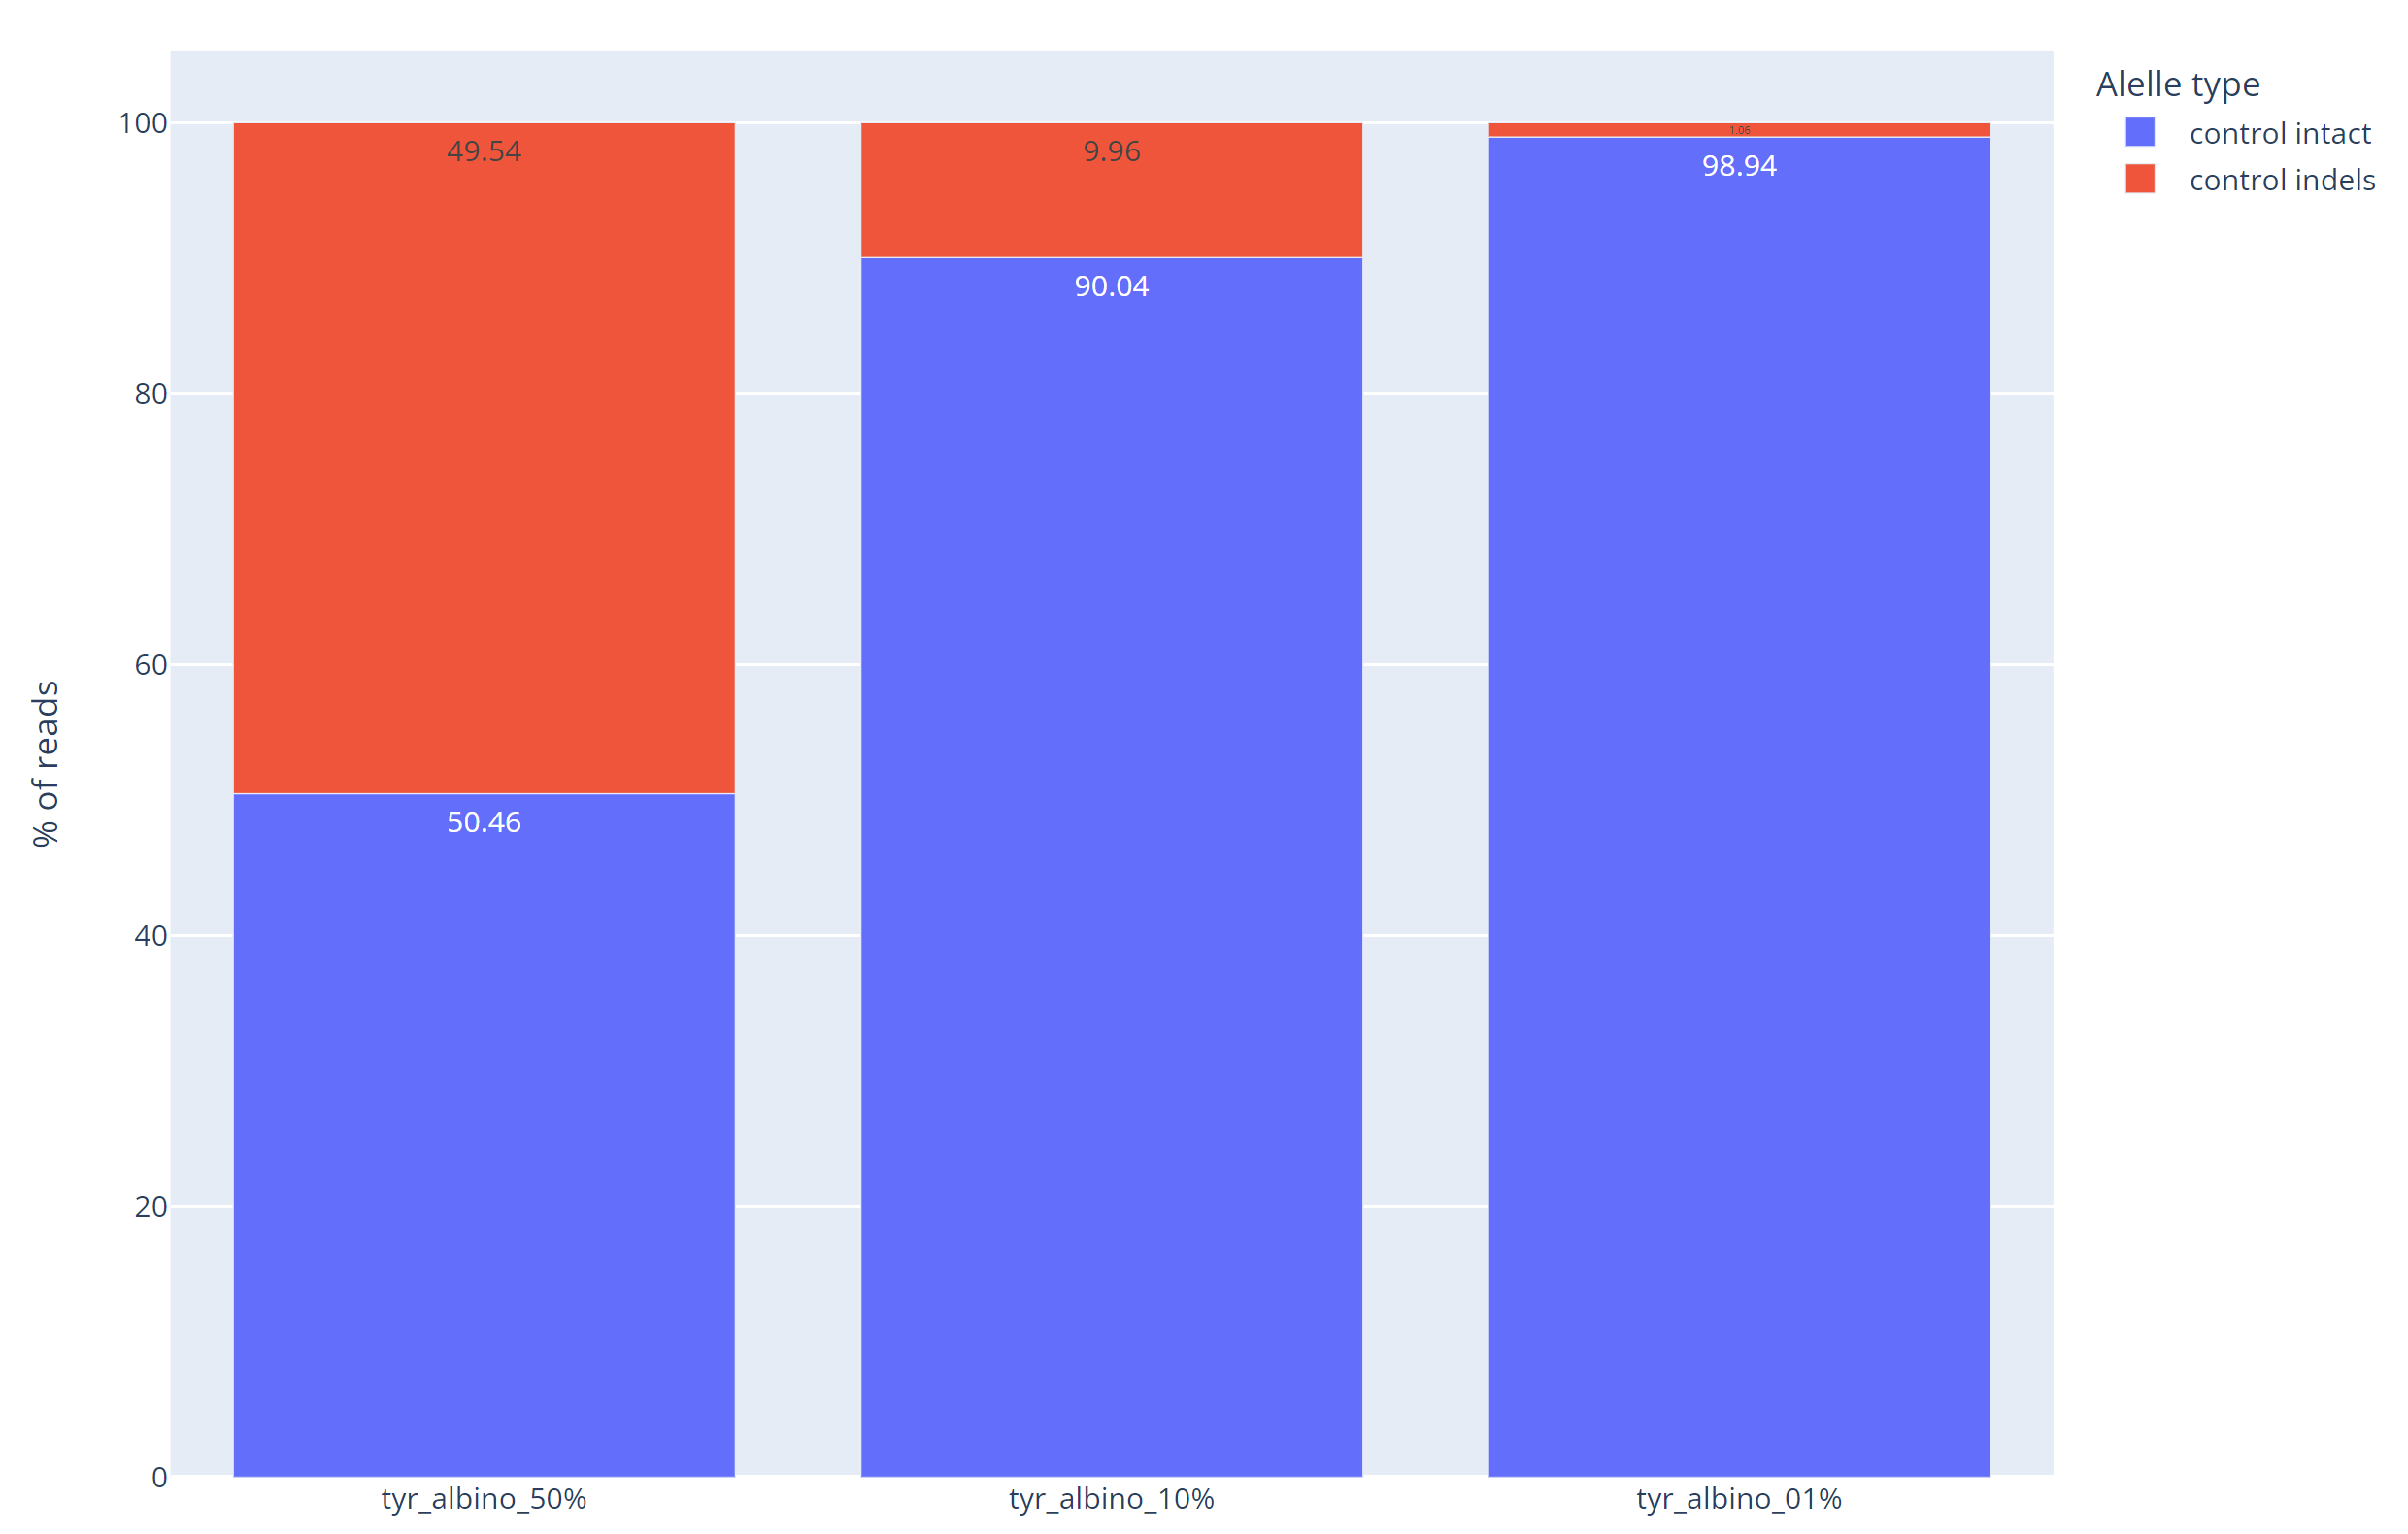

In [20]:
%%bash
rm -rf DAJINResults/single-stx2deletion
rm -rf DAJINResults/.tempdir/single-stx2deletion

time DAJIN2 \
    --name single-stx2deletion \
    --sample "tests/data/knockout/test_barcode25.fq.gz" \
    --control "tests/data/knockout/test_barcode30.fq.gz" \
    --allele "tests/data/knockout/design_stx2.fa" \
    --genome mm10 \
    --threads 10

tests/data/knockout/test_barcode30.fq.gz is now processing...
tests/data/knockout/test_barcode25.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


Finished! Open DAJINResults/single-stx2deletion to see the report.

real	3m57.324s
user	49m13.128s
sys	3m43.735s


- Stx2もいい感じです！

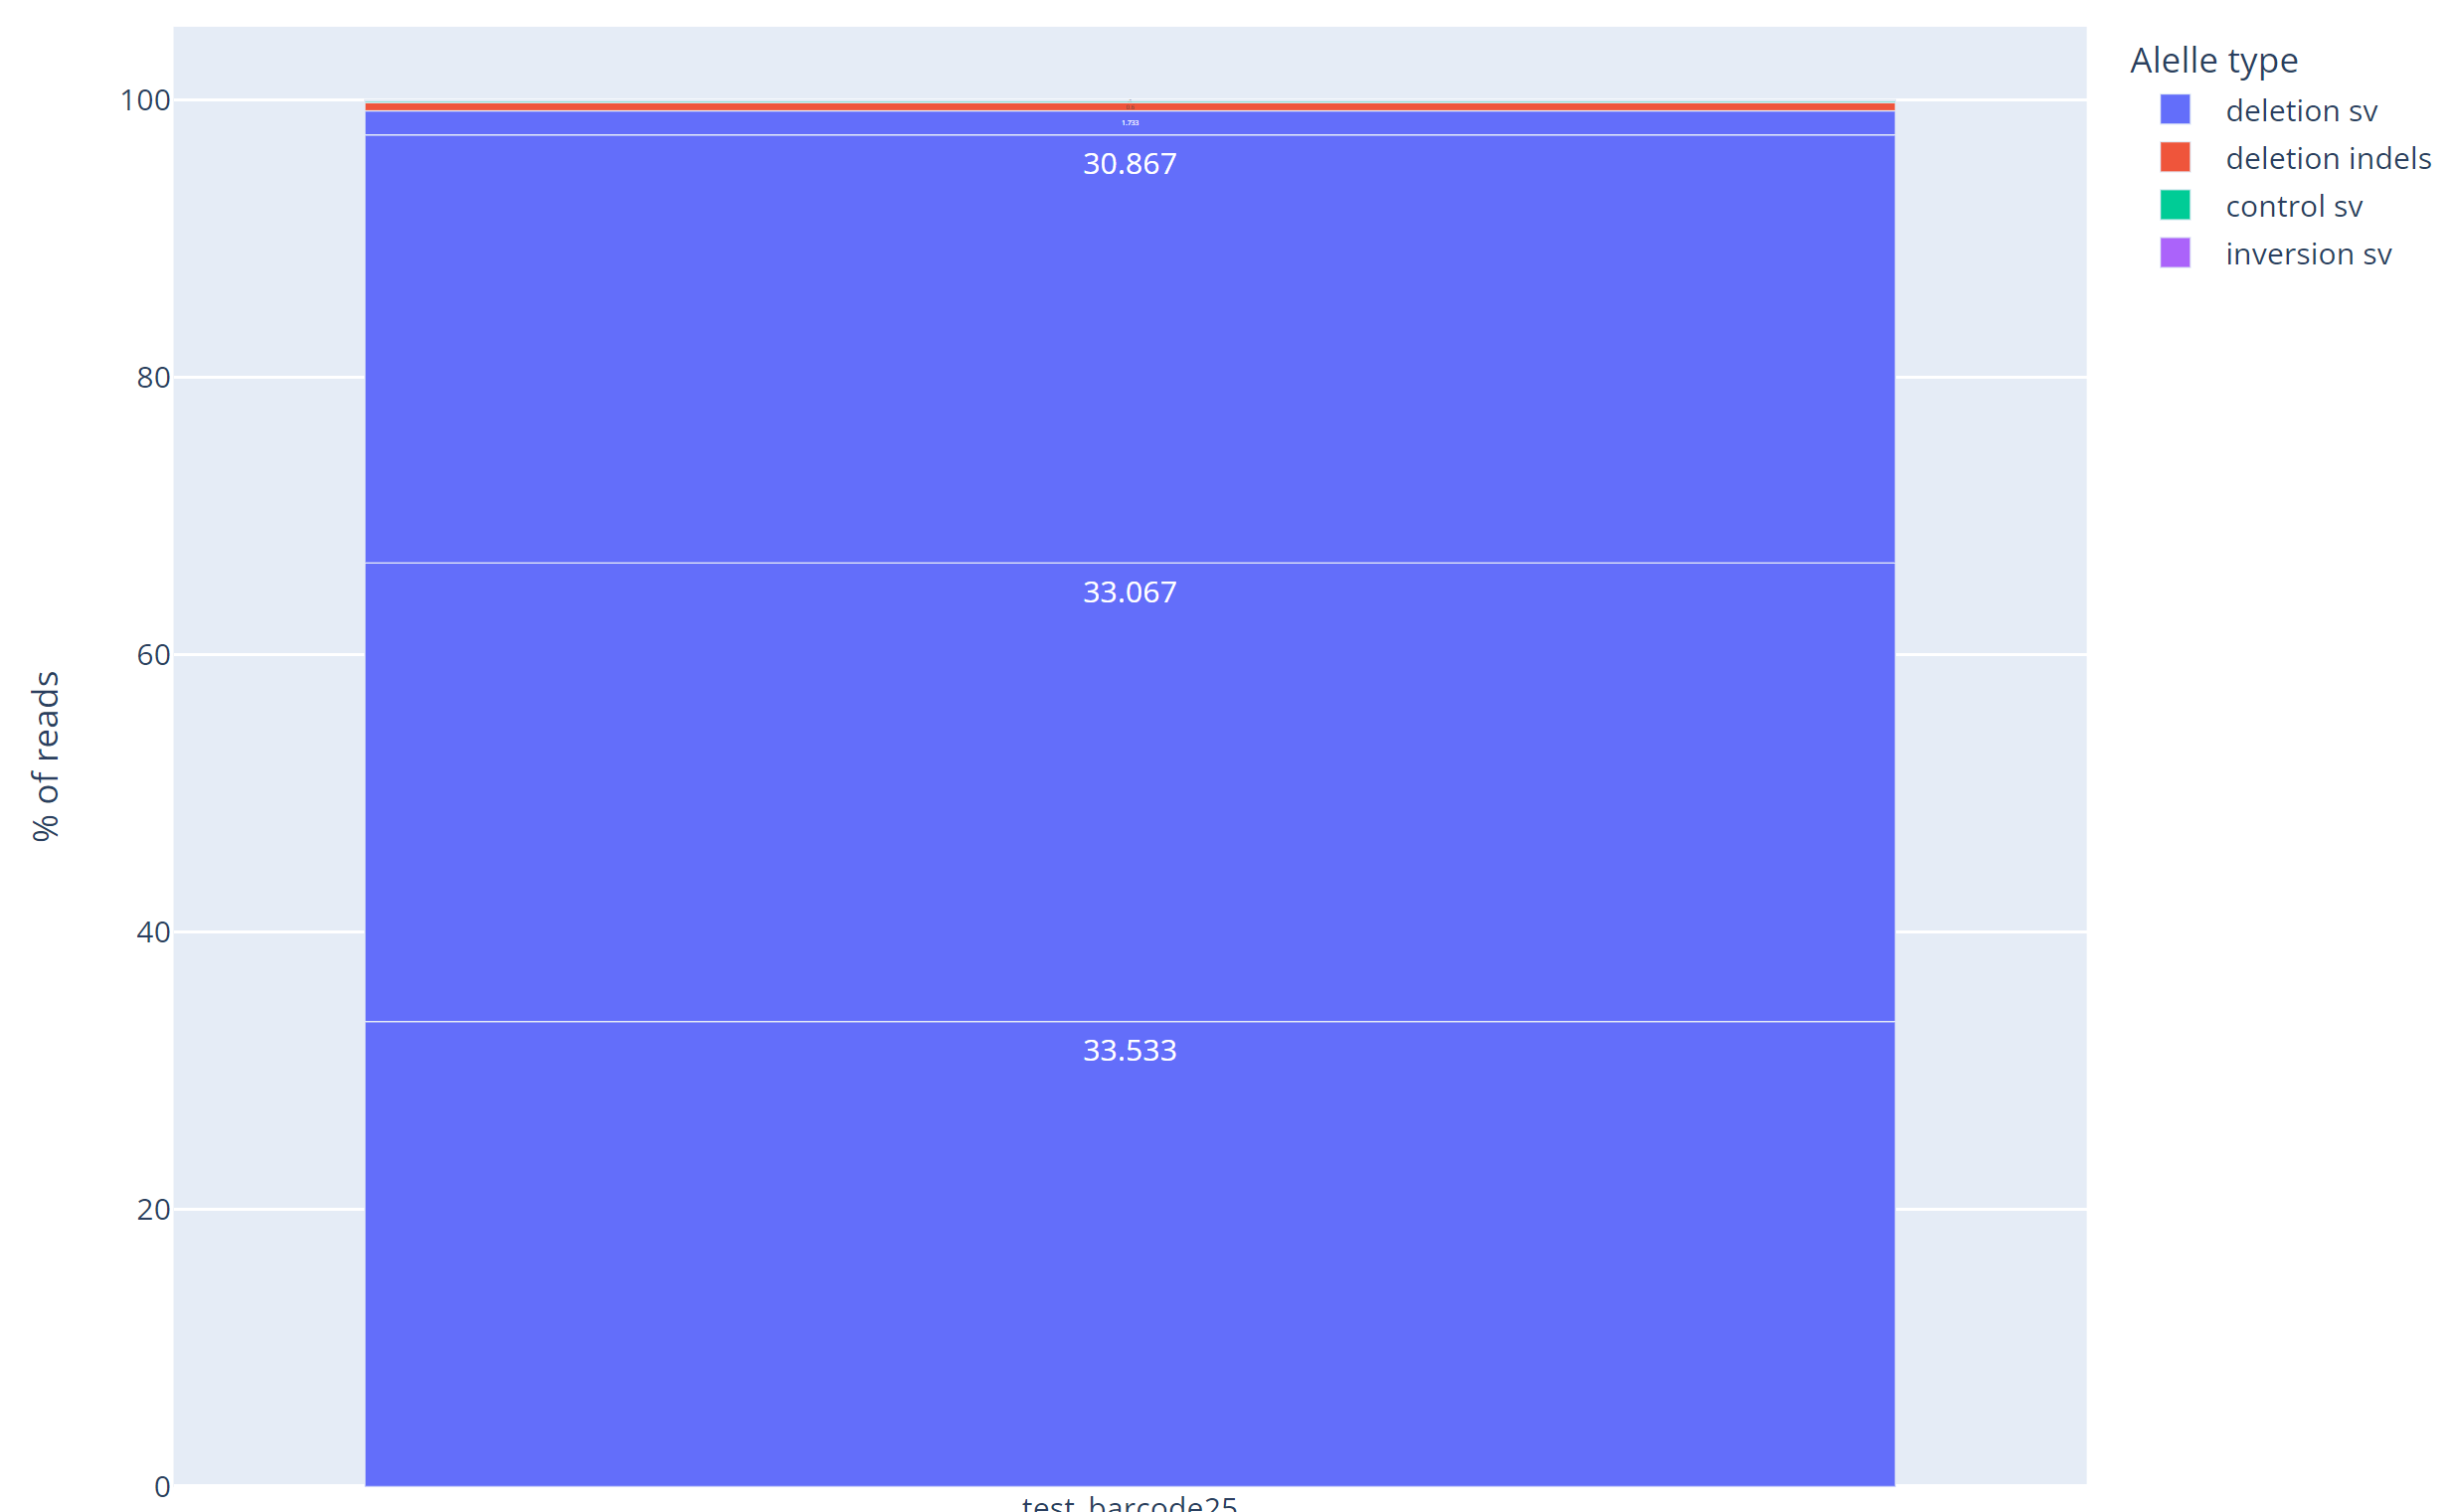

- …とおもったらコンセンサス配列に対して補正が強めに出ていました…

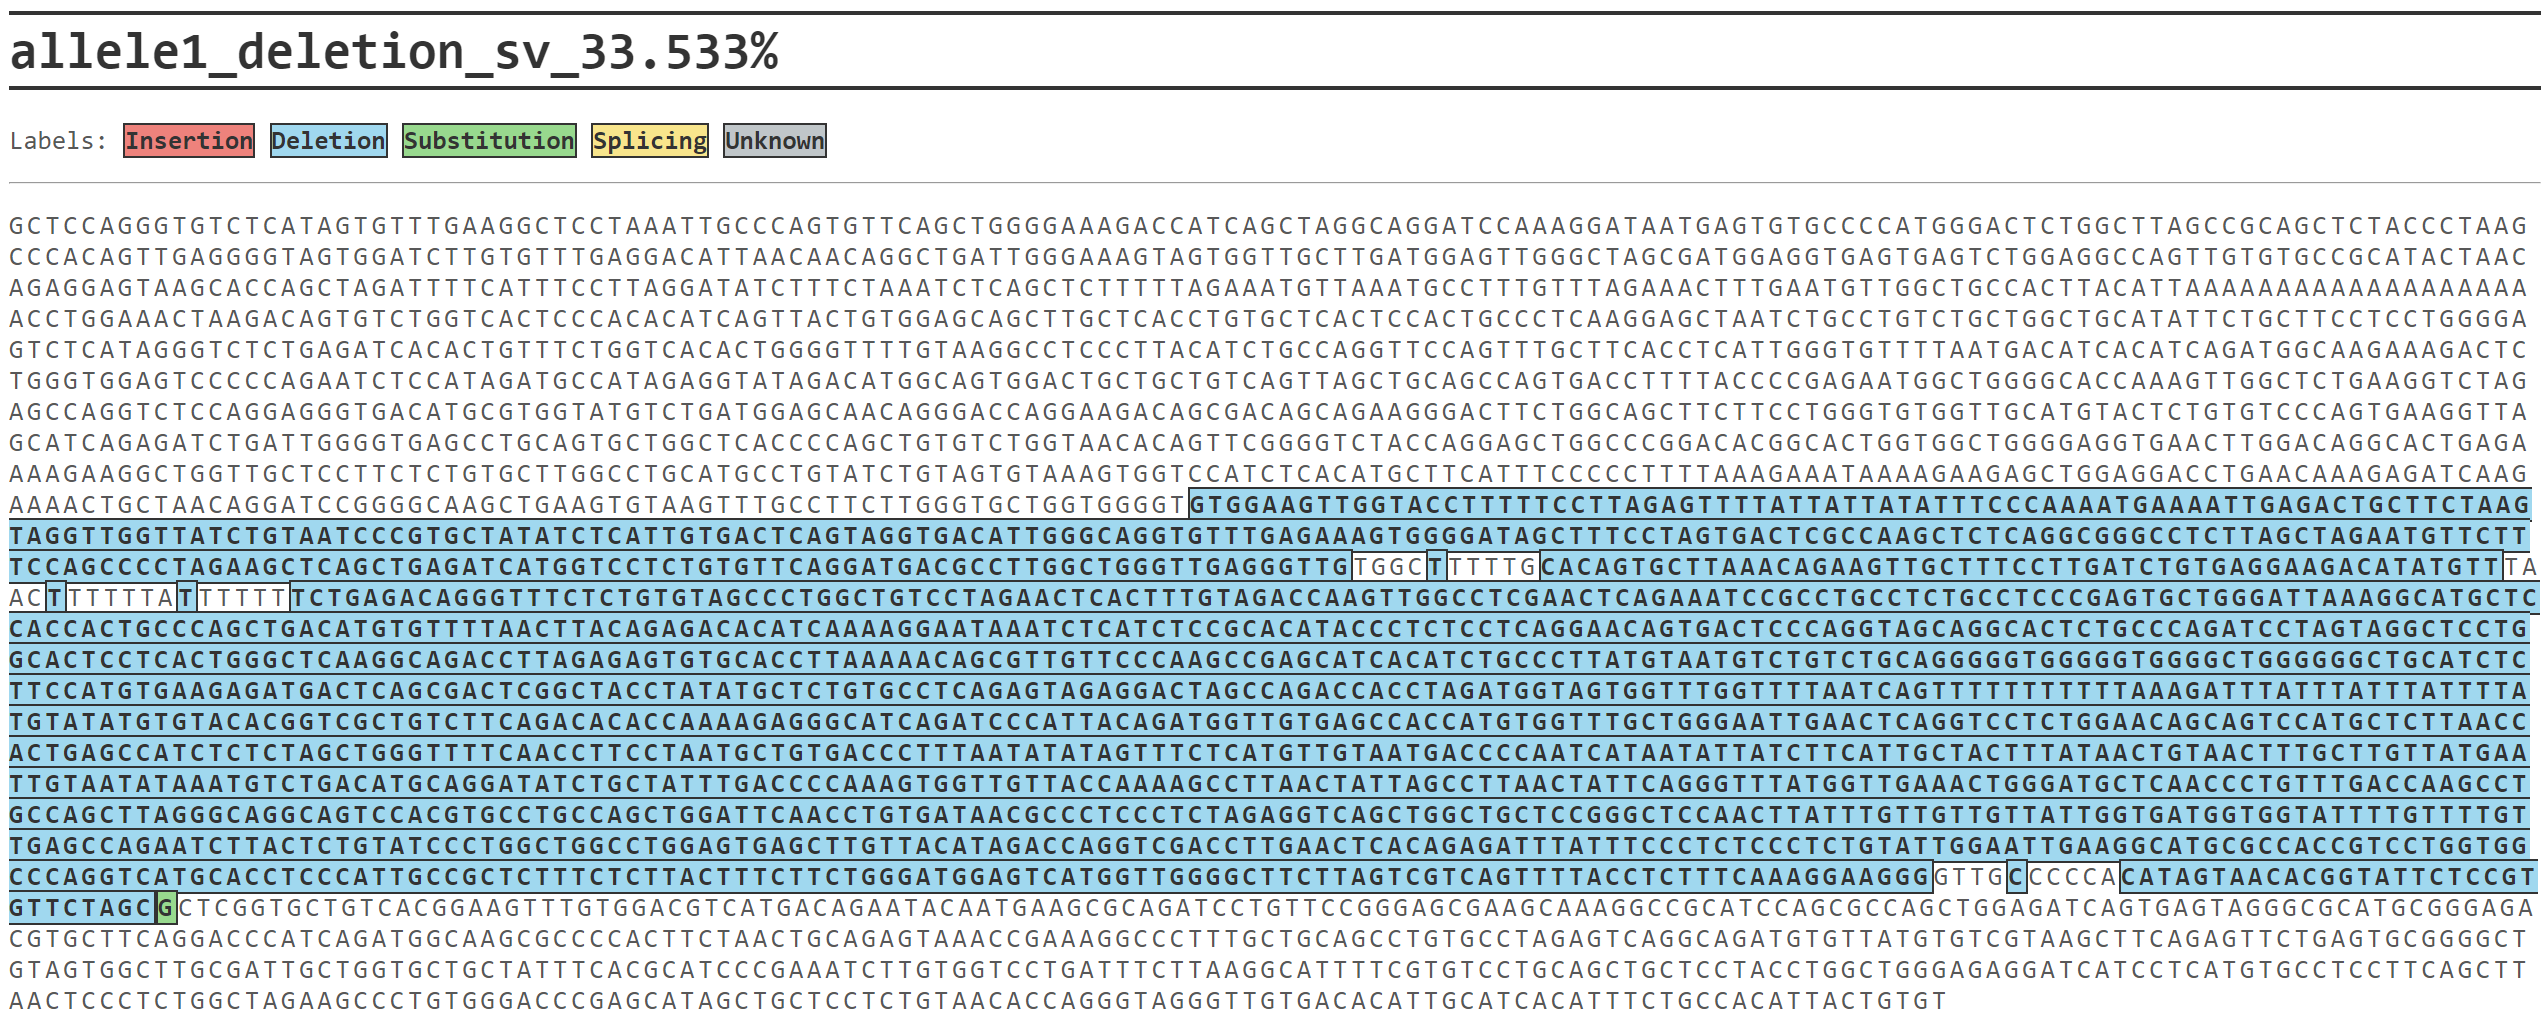

In [21]:
%%bash
rm -rf DAJINResults/single-ayabetask1
rm -rf DAJINResults/.tempdir/single-ayabetask1

time DAJIN2 \
    --name single-ayabetask1 \
    --sample examples/flox-cables2/AyabeTask1/barcode31.fq.gz \
    --control examples/flox-cables2/AyabeTask1/barcode42.fq.gz \
    --allele examples/flox-cables2/AyabeTask1/design_cables2.fa \
    --genome mm10 \
    --threads 10

examples/flox-cables2/AyabeTask1/barcode42.fq.gz is now processing...
examples/flox-cables2/AyabeTask1/barcode31.fq.gz is now processing...


Classify...
Clustering...
Consensus call...


Finished! Open DAJINResults/single-ayabetask1 to see the report.

real	1m38.052s
user	18m18.359s
sys	2m42.303s


- AyabeTask1が残る砦になりそうです
    - inversionも検証が必要ですが…

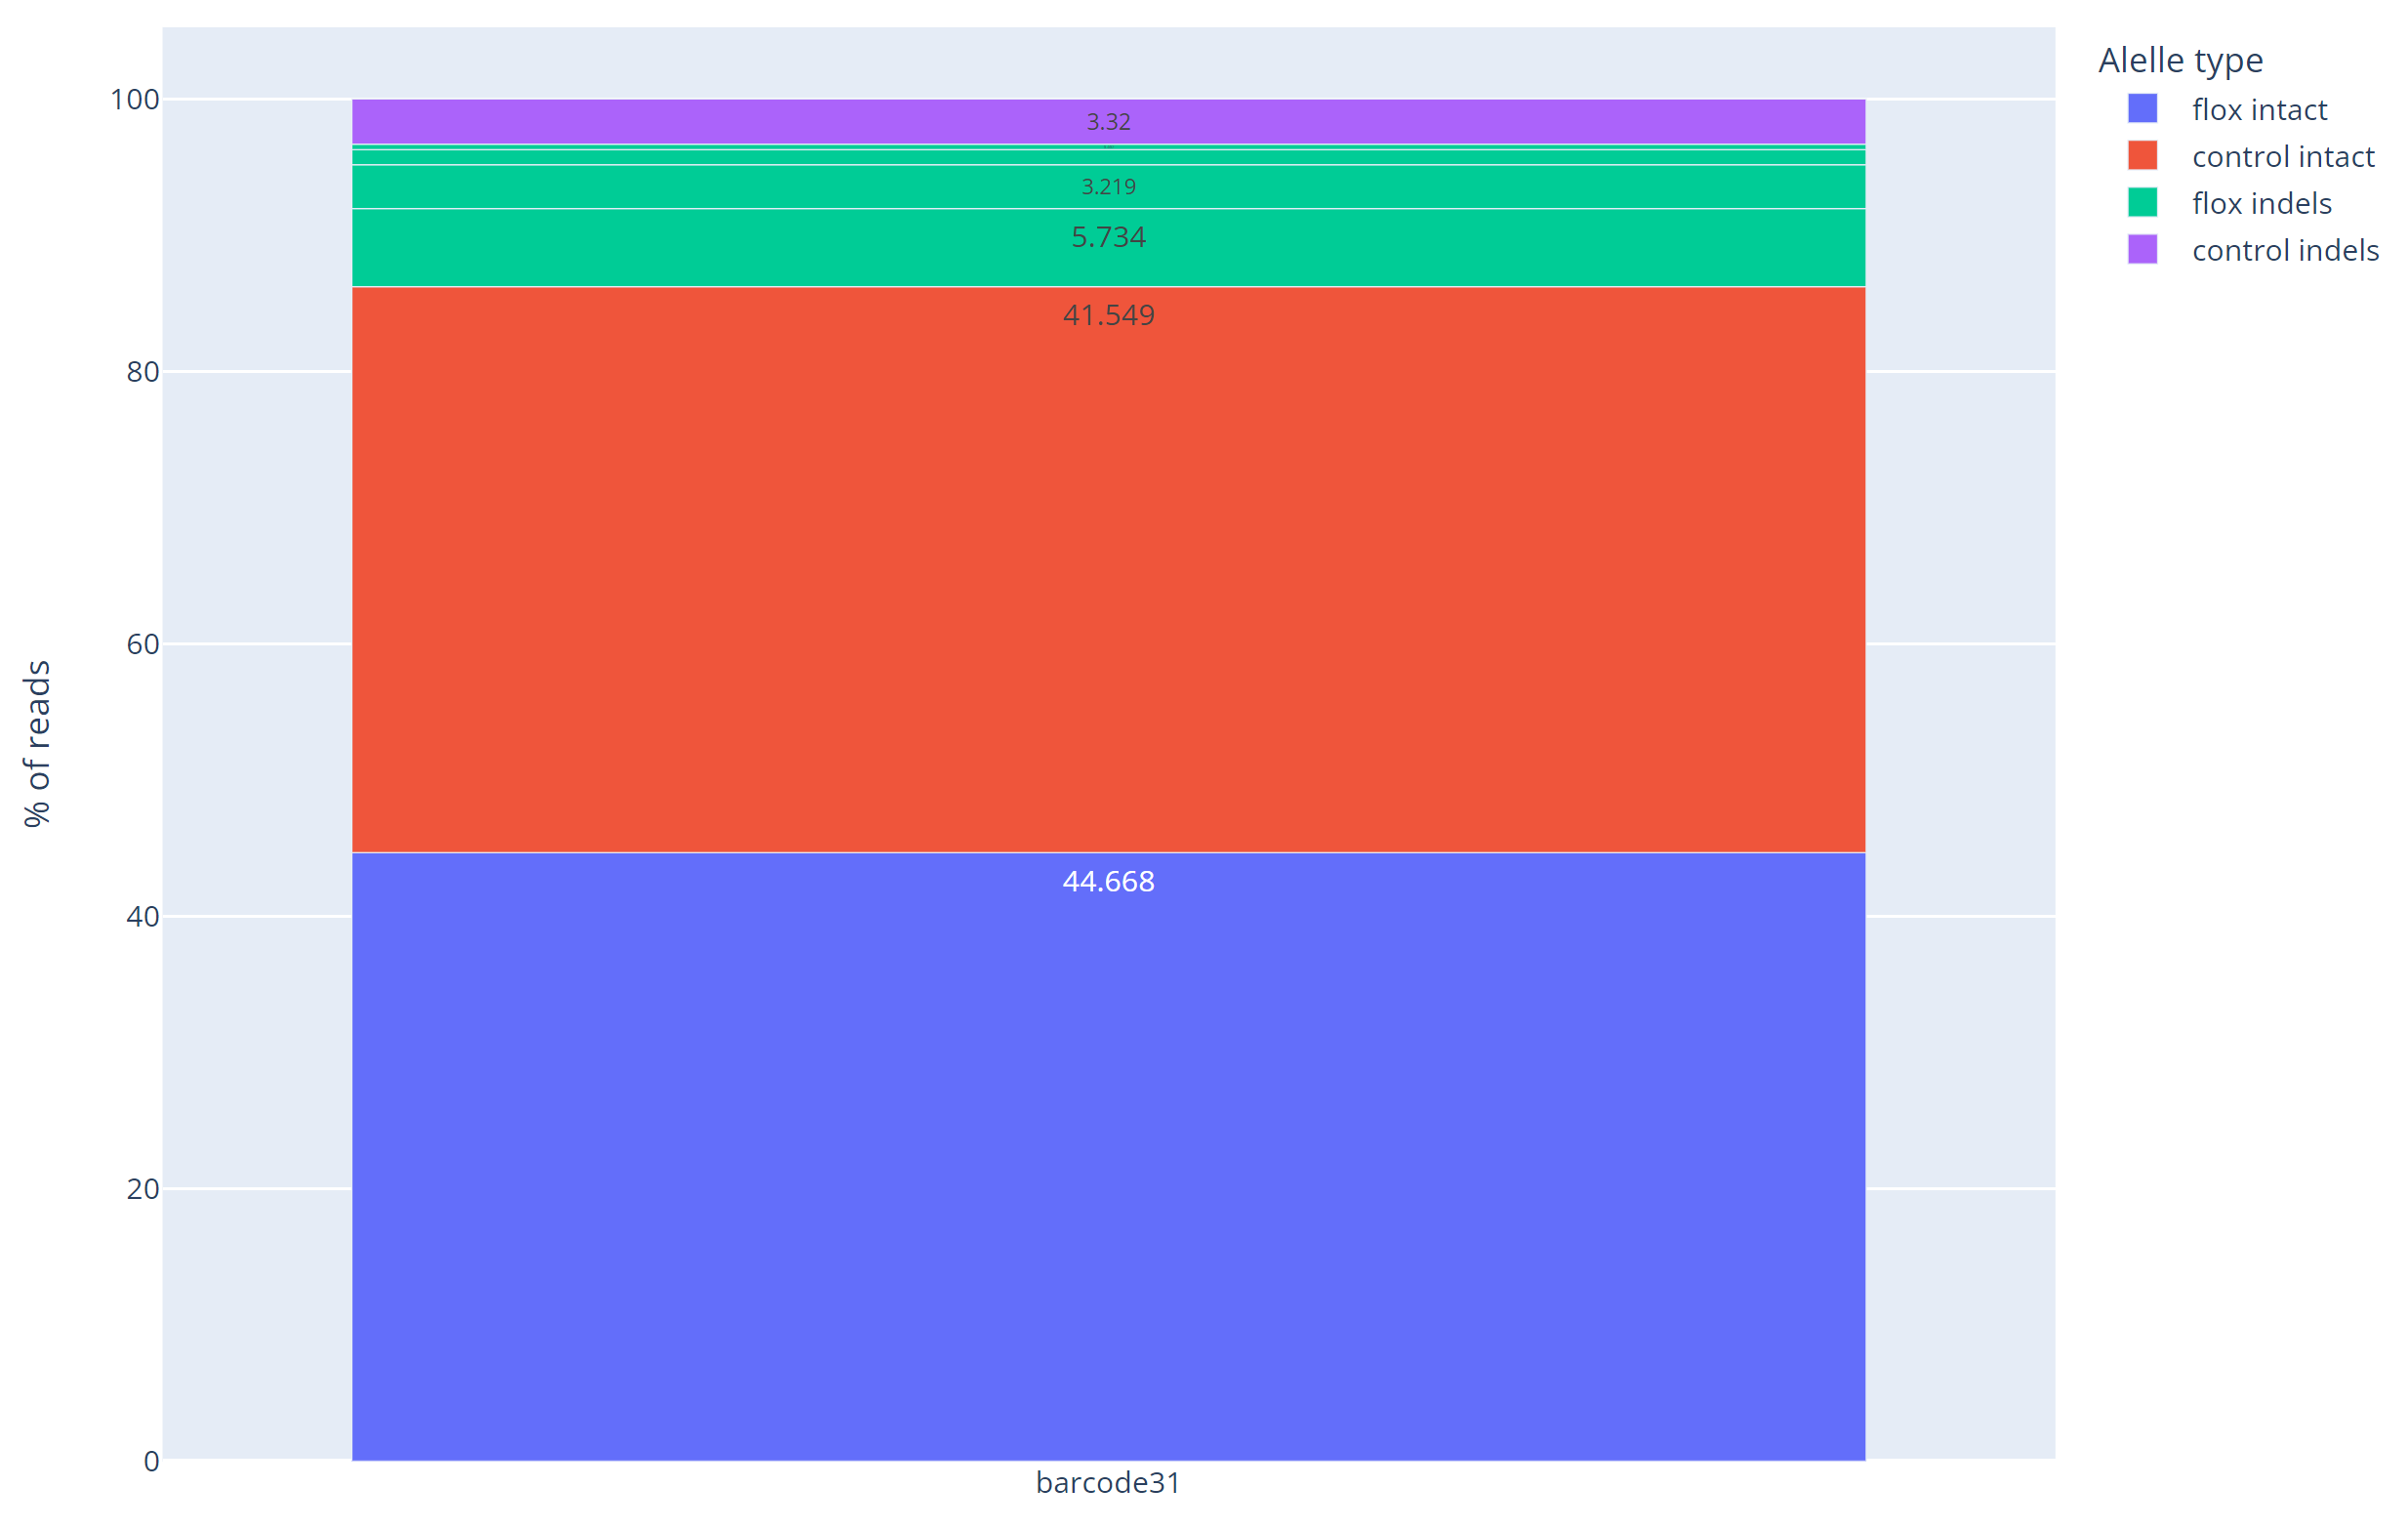

# 👉👉👉 いまここ 👈👈👈

# 👌👌👌 まとめ 👌👌👌


- `correct_sequence_error`のアルゴリズムを変更しました
  - **各kmerごとにLOFをかけることで、いい感じに異常検知ができるようになりました**
      - ナイスアイディアだったと思います！
  - `_remove_minor_allele`を削除しました
  - `_count_indels`の挿入塩基を塩基長を考慮しない形にしました
      - もしかしたら、マイナーな挿入（1リードのみ）以外は塩基長を考慮したほうが良いかもしれません

- Tyrはいい感じでした
- Stx2に対して、補正が強く出ている箇所がありました
- AyabeTask1は改善が必要です
    - Floxはleft/right-loxpがなくなってしまいました

# 次に取り組むこと

- Tyrの動作確認
- ayabe-task1のleft/right-loxpの検出
- mutation_lociをpreprocessで使用したものに変更する

### Lists

+ ⬜ Insertionのなかにある変異を同定する手法を考案する
+ ⬜ Ayabe-taks1のright_loxpがいまいちな理由を考察する
+ ✅ 断端リードの扱いをどうするべきか
+ ✅ `SV`の判定をconsensus callのあとにする
> + ⬜ `preprocess.correct_sequence_error.replace_atmark`のコードがわかりにくい
    + テストを用意してリファクタリングする